# member_personal_training (MPT): Raw Data Discovery & Insights

### Target Attributes: member_id, Session_Date, Session_Type

In [ ]:
import sqlite3
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns

conn = sqlite3.connect(r"__PATH__")

df = pd.read_sql_query("SELECT * FROM member_personal_training", conn)

### Data Understanding, Cleaning & Preparation

In [2]:
df.shape

(206, 13)

In [3]:
df.head()

,pt_row_id,member_id,First Name,Last Name,Trainer Name,Session Date,Session Time,Session Type,Duration (mins),Location,Cost,Status,Notes
0,1,ABC1859,Caleb,Santiago,Anna White,2024-06-15,07:26 PM,HIIT,60,Studio A,$0.00,Completed,Complimentary trial session
1,2,ABC1382,Jane,None,Mike Brown,2025-08-20,07:51 PM,Strength Training,45,Studio C,$45.00,Completed,Focused on upper body
2,3,ABC1252,Brian,Harper,None,2025-05-10,05:49 PM,Yoga & Flexibility,30,Studio C,$0.00,None,Complimentary trial session
3,4,ABC1794,Barry,Anderson,David Park,2024-04-12,08:31 AM,Yoga & Flexibility,45,Studio C,$45.00,Completed,Introduced new poses
4,5,ABC1051,William,Ramirez,Anna White,2025-02-17,04:08 PM,Functional Training,60,Studio B,$60.00,Completed,Improved squat form


In [4]:
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace(" ", "_")
df.columns

Index(['pt_row_id', 'member_id', 'first_name', 'last_name', 'trainer_name',
       'session_date', 'session_time', 'session_type', 'duration_(mins)',
       'location', 'cost', 'status', 'notes'],
      dtype='object')

In [5]:
df = df[[
       #'pt_row_id', 
       'member_id', 
       #'first_name', 'last_name', 'trainer_name',
       'session_date', 'session_time', 'session_type' 
       #'duration', 'location',
       #'cost', 'status', 'notes'
       ]].copy()

In [6]:
df.head(2)

,member_id,session_date,session_time,session_type
0,ABC1859,2024-06-15,07:26 PM,HIIT
1,ABC1382,2025-08-20,07:51 PM,Strength Training


In [7]:
df['session_date'] = pd.to_datetime(df['session_date'])

In [8]:
df['session_time'] = pd.to_datetime(df['session_time'], format="%I:%M %p").dt.time

In [9]:
df.head()

,member_id,session_date,session_time,session_type
0,ABC1859,2024-06-15,19:26:00,HIIT
1,ABC1382,2025-08-20,19:51:00,Strength Training
2,ABC1252,2025-05-10,17:49:00,Yoga & Flexibility
3,ABC1794,2024-04-12,08:31:00,Yoga & Flexibility
4,ABC1051,2025-02-17,16:08:00,Functional Training


In [10]:
df['session_type'].unique()

array(['HIIT', 'Strength Training', 'Yoga & Flexibility',
       'Functional Training'], dtype=object)

In [11]:
df['session_type'] = df['session_type'].str.lower().str.replace(' ', '_')
df['session_type'].unique()

array(['hiit', 'strength_training', 'yoga_&_flexibility',
       'functional_training'], dtype=object)

In [12]:
df.isna().sum()

member_id       0
session_date    0
session_time    0
session_type    0
dtype: int64

In [13]:
df.head()

,member_id,session_date,session_time,session_type
0,ABC1859,2024-06-15,19:26:00,hiit
1,ABC1382,2025-08-20,19:51:00,strength_training
2,ABC1252,2025-05-10,17:49:00,yoga_&_flexibility
3,ABC1794,2024-04-12,08:31:00,yoga_&_flexibility
4,ABC1051,2025-02-17,16:08:00,functional_training


In [14]:
df[df['member_id'] == "ABC1382"]

,member_id,session_date,session_time,session_type
1,ABC1382,2025-08-20,19:51:00,strength_training
131,ABC1382,2025-08-20,18:21:00,yoga_&_flexibility
182,ABC1382,2025-08-19,07:43:00,strength_training
200,ABC1382,2025-08-20,19:51:00,strength_training


In [15]:
df["total_pt_sessions"] = df.groupby("member_id")["session_type"].transform("count")

df[df['member_id'] == "ABC1382"]

,member_id,session_date,session_time,session_type,total_pt_sessions
1,ABC1382,2025-08-20,19:51:00,strength_training,4
131,ABC1382,2025-08-20,18:21:00,yoga_&_flexibility,4
182,ABC1382,2025-08-19,07:43:00,strength_training,4
200,ABC1382,2025-08-20,19:51:00,strength_training,4


In [16]:
member_fav_pt = (
    df.groupby(['member_id', 'session_type'])
      .size()
      .reset_index(name='count')
)

# Pick pt with max count per member
member_fav_pt = member_fav_pt.loc[
    member_fav_pt.groupby('member_id')['count'].idxmax()
]

member_fav_pt = member_fav_pt[['member_id', 'session_type']].rename(
    columns={'session_type': 'favorite_pt_session'}
)

df = df.merge(member_fav_pt, on="member_id", how="left")

df[df['member_id'] == "ABC1382"]

,member_id,session_date,session_time,session_type,total_pt_sessions,favorite_pt_session
1,ABC1382,2025-08-20,19:51:00,strength_training,4,strength_training
131,ABC1382,2025-08-20,18:21:00,yoga_&_flexibility,4,strength_training
182,ABC1382,2025-08-19,07:43:00,strength_training,4,strength_training
200,ABC1382,2025-08-20,19:51:00,strength_training,4,strength_training


In [17]:
# extract features
df['day_of_week'] = df['session_date'].dt.day_name()
df['hour'] = df['session_time'].apply(lambda t: t.hour)

# favorite day
fav_day = (
    df.groupby('member_id')['day_of_week']
      .agg(lambda x: x.mode()[0])
      .reset_index(name='favorite_day')
)

# favorite hour
fav_hour = (
    df.groupby('member_id')['hour']
      .agg(lambda x: x.mode()[0])
      .reset_index(name='favorite_hour')
)

# merge back
df = df.merge(fav_day, on='member_id', how='left')
df = df.merge(fav_hour, on='member_id', how='left')

df[df['member_id'] == "ABC1382"]

,member_id,session_date,session_time,session_type,total_pt_sessions,favorite_pt_session,day_of_week,hour,favorite_day,favorite_hour
1,ABC1382,2025-08-20,19:51:00,strength_training,4,strength_training,Wednesday,19,Wednesday,19
131,ABC1382,2025-08-20,18:21:00,yoga_&_flexibility,4,strength_training,Wednesday,18,Wednesday,19
182,ABC1382,2025-08-19,07:43:00,strength_training,4,strength_training,Tuesday,7,Wednesday,19
200,ABC1382,2025-08-20,19:51:00,strength_training,4,strength_training,Wednesday,19,Wednesday,19


In [18]:
# last session date per member
last_session = (
    df.groupby('member_id')['session_date']
      .max()
      .reset_index(name='latest_session')
)

# now build the member-level table
member_features = (
    df[['member_id','total_pt_sessions','favorite_pt_session','favorite_day','favorite_hour']]
    .drop_duplicates('member_id')
    .merge(last_session, on='member_id', how='left')
)

member_features[member_features['member_id'] == "ABC1382"]

,member_id,total_pt_sessions,favorite_pt_session,favorite_day,favorite_hour,latest_session
1,ABC1382,4,strength_training,Wednesday,19,2025-08-20


In [19]:
member_features.head(6)

,member_id,total_pt_sessions,favorite_pt_session,favorite_day,favorite_hour,latest_session
0,ABC1859,2,hiit,Saturday,6,2024-06-15
1,ABC1382,4,strength_training,Wednesday,19,2025-08-20
2,ABC1252,2,strength_training,Saturday,17,2025-05-10
3,ABC1794,2,functional_training,Friday,8,2024-04-12
4,ABC1051,2,functional_training,Monday,16,2025-02-17
5,ABC1250,1,yoga_&_flexibility,Tuesday,8,2024-04-23


In [20]:
member_features.shape

(139, 6)

### Load to clean_db

In [ ]:
con_out = sqlite3.connect(r"__PATH__")
member_features.to_sql("member_PT", con_out, if_exists="replace", index=False)
con_out.close()

## Exploration

In [22]:
# Order the days
dow_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

# Count how many members have each favorite_day
dow_pt_counts = (
    member_features['favorite_day']
    .value_counts()
    .reindex(dow_order, fill_value=0)
)

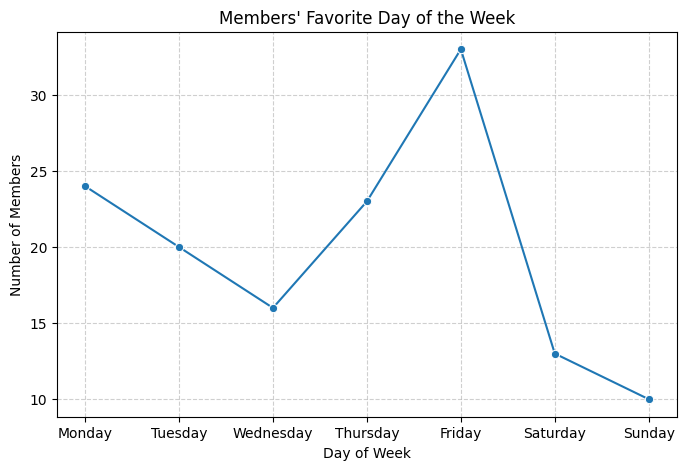

In [23]:
plt.figure(figsize=(8,5))
sns.lineplot(x=dow_pt_counts.index, y=dow_pt_counts.values, marker="o")
plt.title("Members' Favorite Day of the Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Members")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [24]:
pt_session_counts = member_features['favorite_pt_session'].value_counts()
pt_session_counts

favorite_pt_session
functional_training    52
strength_training      36
hiit                   35
yoga_&_flexibility     16
Name: count, dtype: int64

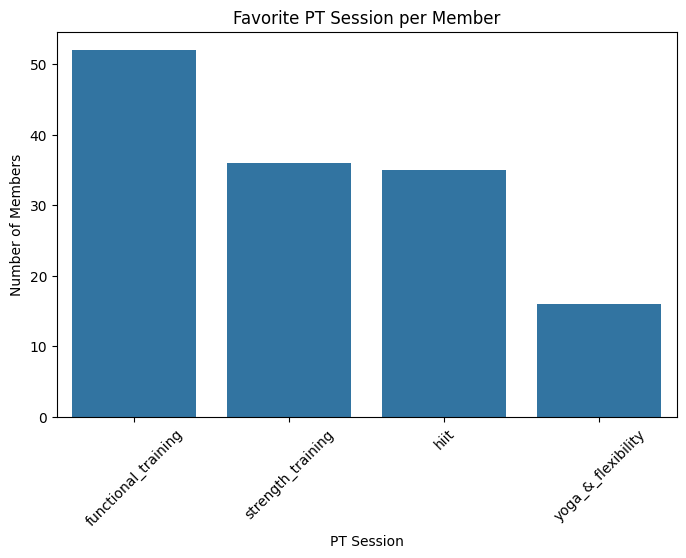

In [25]:
plt.figure(figsize=(8,5))
sns.barplot(x=pt_session_counts.index, y=pt_session_counts.values)
plt.title("Favorite PT Session per Member")
plt.xlabel("PT Session")
plt.ylabel("Number of Members")
plt.xticks(rotation=45)
plt.show()

In [26]:
# ordered days
days_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
dow_dtype = pd.CategoricalDtype(days_order, ordered=True)

# make sure favorite_day is ordered categorical
member_features['favorite_day'] = member_features['favorite_day'].astype(dow_dtype)

# pivot: rows = day, cols = hour, values = # of members
heatmap_pivot = (
    member_features.groupby(['favorite_day','favorite_hour'], observed=True)
      .size()
      .unstack(fill_value=0)
      .reindex(days_order)        # keep rows in weekday order
      .sort_index(axis=1)         # keep hours in order
)

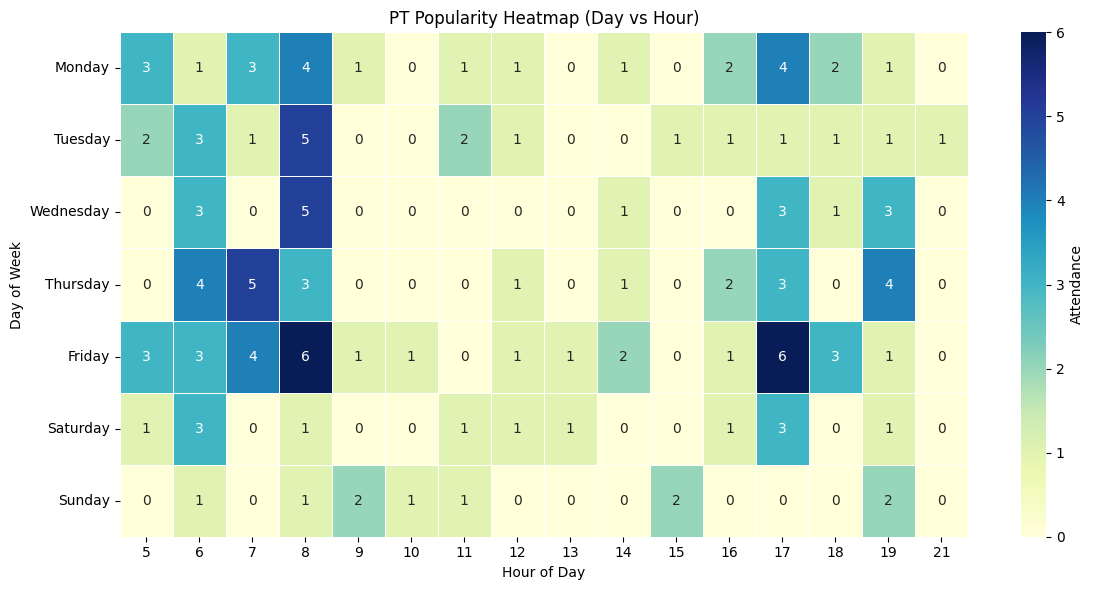

In [27]:
# 4) Plot
plt.figure(figsize=(12,6))
sns.heatmap(
    heatmap_pivot, annot=True, fmt=".0f",
    cmap="YlGnBu", linewidths=.5, cbar_kws={"label": "Attendance"}
)
plt.title("PT Popularity Heatmap (Day vs Hour)")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()